# Advanced geomechanics - WP3

Renato Poli (rep2656)

09/17/2023

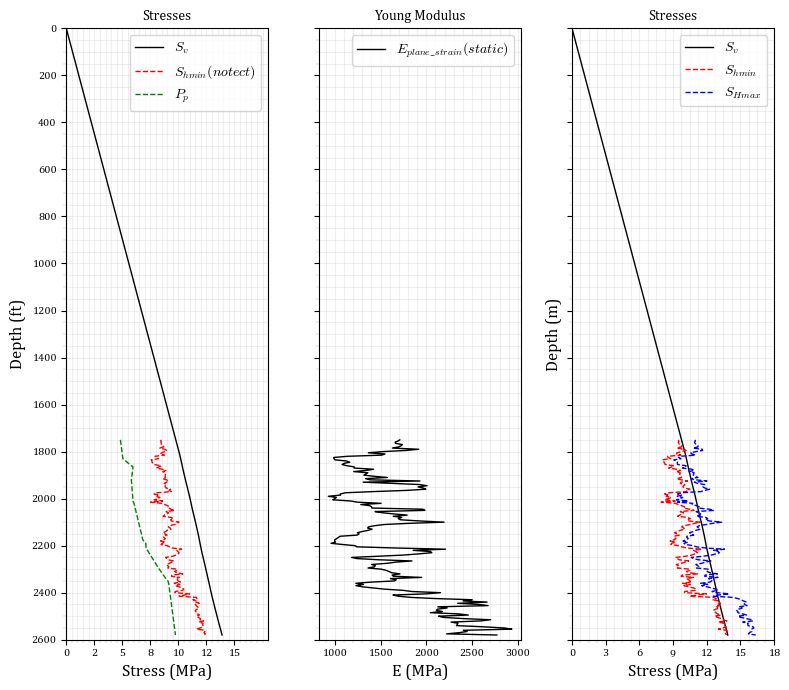

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')   ## reset!
plt.style.use('paper.mplstyle')

# depth_ft	Pp_psi	dens_g_cc	dtc_us_ft	dts_us_ft	por
# [ft]      [psi]   [g/cc]      [us/ft]     [us/ft]     [-]
df = pd.read_excel("LostHills.xlsx")

# Convert to SI
df["depth"] = df.depth_ft * 0.3048    # m
df["dens"] = df.dens_g_cc * 1000      # kg/m3
df["Pp"] = df.Pp_psi * 6894.76        # Pa
df["dtc"] = df.dtc_us_ft * 1e-6 / 0.3048 # s/m
df["dts"] = df.dts_us_ft * 1e-6 / 0.3048 # s/m
df["Vp"] = 1 / df.dtc # m/s
df["Vs"] = 1 / df.dts # m/s

# Compute Sv
df["prev_dens"] = df.dens.shift().fillna(1870)
#                      kg/m3                       g[m/s2]   = $ Svgrad [Pa/m]
df["SvGrad"] = ( df.dens/2 + df.prev_dens/2 ) *    9.8     
df['DeltaDepth'] = df.depth_ft.diff().shift(-1) * 0.3048
df['dSv'] = df.DeltaDepth * df.SvGrad
df['Sv'] = df.dSv.shift().cumsum().fillna(0)
df['Sv_MPa'] = df.Sv / 1e6

# Effective stresses
df["Sig_v"] = df.Sv - df.Pp

# Edyn, vdin
df["E_dyn"] = df.dens * ( df.Vs**2 ) * ( 3 * df.Vp**2 - 4 * df.Vs**2 ) / ( df.Vp**2 - df.Vs**2 )
df["poisson_dyn"] = ( df.Vp**2 - 2 * df.Vs**2 ) / 2 / ( df.Vp**2 - df.Vs**2 )

df["E"] = 0.65 * df.E_dyn
df["poisson"] = df.poisson_dyn 

df["E_plane_strain"] = df.E / ( 1 - df.poisson**2 )
df["E_plane_strain_MPa"] = df.E_plane_strain / 1E6

# Shmin, no tectonic
df["Sigma_hmin_notect"] = df.poisson / ( 1 - df.poisson ) * df.Sig_v
df["Shmin_notect"] = df.Sigma_hmin_notect + df.Pp
df["Shmin_notect_MPa"] = df.Shmin_notect / 1e6

# Effective horizontal stresses
# Sigma_hmin, Sigma_hmax, tectonic stresses eps_hmax = 0.0015   eps_hmin=0
df["Sigma_hmin"] = df.poisson / ( 1 - df.poisson ) * df.Sig_v + df.E_plane_strain * 0.0015 * df.poisson
df["Sigma_hmax"] = df.poisson / ( 1 - df.poisson ) * df.Sig_v + df.E_plane_strain * 0.0015

df["Shmin"] = df.Sigma_hmin + df.Pp
df["Shmax"] = df.Sigma_hmax + df.Pp

# Units
df["Shmin_MPa"] = df.Shmin / 1e6
df["Shmax_MPa"] = df.Shmax / 1e6


fig, [ax1, ax2, ax3] = plt.subplots( 1, 3, sharey=True )
fig.set_size_inches(8,7)

## Plot Stressees
ax = ax1
ax.plot(df.Sv_MPa, df.depth_ft, label="$S_v$", c='k')
ax.plot(df.Shmin_notect_MPa, df.depth_ft, '--', label="$S_{hmin} (no tect)$", c='r')
ax.plot(df.Pp/1e6, df.depth_ft, '--', label="$P_p$", c='green')
ax.set_xlim(0,18)
ax.set_ylim(0,2500)

ax.set_xlabel("Stress (MPa)")
ax.set_ylabel("Depth (ft)")
ax.set_xticks( np.linspace(0, 15, 7) )
ax.set_yticks( np.linspace(0, 2600, 14) )
ax.set_title("Stresses")
from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.invert_yaxis()
ax.legend()

## Plot Young modulus
ax = ax2
ax.plot(df.E_plane_strain_MPa, df.depth_ft, label="$E_{plane\_strain} (static)$", c='k')
# ax.set_xlim(0,3)
ax.set_xlabel("E (MPa)")
# ax.set_xticks( np.linspace(0, 3, 5) )
ax.set_title("Young Modulus")
from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.invert_yaxis()
ax.legend()

## Plot stresses under tectonic strains
ax = ax3
ax.plot(df.Sv_MPa, df.depth_ft, label="$S_v$", c='k')
ax.plot(df.Shmin_MPa, df.depth_ft, '--', label="$S_{hmin}$", c='r')
ax.plot(df.Shmax_MPa, df.depth_ft, '--', label="$S_{Hmax}$", c='b')


ax.set_xlim(0,18)
ax.set_xlabel("Stress (MPa)")
ax.set_ylabel("Depth (m)")
ax.set_xticks( np.linspace(0, 18, 7) )
ax.set_title("Stresses")
from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.legend()

ax.invert_yaxis()
fig.tight_layout()


The pay-zone is between 2,100 ft and 2,450 ft. A hydraulic fracture is planned to be executed with a vertical well at a depth between 2,130 ft and 2,160 ft. What will be the height of this fracture? Will it reach out to the entire pay zone?

---

*Likely to fracture from 2135 to 2200 ft (Estimated height: 65 ft).*

*The fracture starts at $P_{inj}$ around 9.4 MPa (13,600 psi) and opens downwards, where stresses are lower.*


Likely to fracture from 2145 to 2195 ft (Estimated height: 50 ft).


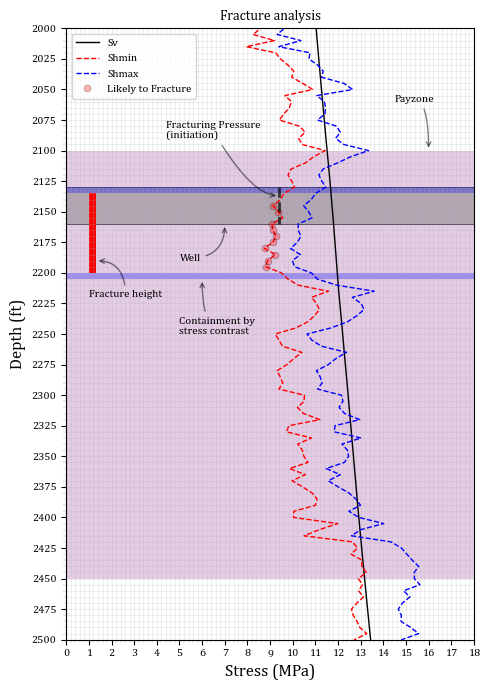

In [3]:
Frac_press = 9.4

plt.style.use('default')   ## reset!
plt.style.use('paper.mplstyle')

# Estimate fracture height
df["Frac_MPa"] = df.Shmin_MPa

# Likely to fracture
mask2 = ( df.Shmin_MPa < Frac_press ) & ( df.depth_ft > 2100) & ( df.depth_ft < 2210)
dfm2 = df[mask2]

likely_to_frac_range = [ dfm2.depth_ft.min(), dfm2.depth_ft.max(), dfm2.depth_ft.max() - dfm2.depth_ft.min() ]

print(f"Likely to fracture from {likely_to_frac_range[0]} to {likely_to_frac_range[1]} ft (Estimated height: {likely_to_frac_range[2]} ft).")

# Plot
fig, ax = plt.subplots( 1, 1, sharey=True )
fig.set_size_inches(5,7)

## Plot stresses under tectonic strains
ax.plot(df.Sv_MPa, df.depth_ft, label="Sv", c='k')
ax.plot(df.Shmin_MPa, df.depth_ft, '--', label="Shmin", c='r')
ax.plot(df.Shmax_MPa, df.depth_ft, '--', label="Shmax", c='b')
# ax.plot(df.Frac_MPa, df.depth_ft, 'o', label="Fracture", c='k', linewidth=1,  markersize=7)

# Likely to fracture
ax.plot(dfm2.Frac_MPa, dfm2.depth_ft, 'o', label="Likely to Fracture", c='red', markersize=5, markeredgewidth=.5, markeredgecolor='k', alpha=.3)

ax.set_xlim(0,18)
ax.set_xlabel("Stress (MPa)")
ax.set_ylabel("Depth (ft)")
ax.set_xticks( np.linspace(0, 18, 19) )
ax.set_yticks( np.linspace(2000, 2500, 21) )
ax.set_ylim(2000,2500)
ax.set_title("Fracture analysis")
from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.legend( fontsize=8 )

# Add rectangle
import matplotlib.patches as mpatches
# Payzone
rect=mpatches.Rectangle((0,2100),18,350, fill=True, alpha=0.2, color="purple", linewidth=0)
fig.gca().add_patch(rect)

# Vertical well - fracture start
rect=mpatches.Rectangle((0,2130),18,30, fill=True, alpha=0.5, color="gray", linewidth=0)
fig.gca().add_patch(rect)
rect=mpatches.Rectangle((0,2130),18,30, fill=False, alpha=1.0, color="k", linewidth=.5)
fig.gca().add_patch(rect)

# Fracture containment
for fc in [ 2130, 2200 ] :
        rect=mpatches.Rectangle((0,fc),18,5, fill=True, alpha=0.3, color="blue", linewidth=0)
        fig.gca().add_patch(rect)

# Likely to fracture
rect=mpatches.Rectangle((1,2135),.3,65,fill=True, alpha=1, color="red", linewidth=0)
fig.gca().add_patch(rect)

ax.vlines(x = Frac_press, ymin = 2130, ymax = 2160, colors = 'k', label = 'Fracturing pressure', linewidth=2, linestyle='--', alpha=.7)
ax.annotate("Fracturing Pressure\n(initiation)", (Frac_press,2137), xytext=(Frac_press-5,2090), fontsize=8,
        arrowprops = dict(  arrowstyle="->", connectionstyle="angle3,angleA=-60,angleB=0", alpha=0.5))


ax.annotate("Containment by\nstress contrast", (6,2205), xytext=(5,2250), fontsize=8,
        arrowprops = dict(  arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90", alpha=0.5))

ax.annotate("Payzone", (16,2100), xytext=(14.5,2060), fontsize=8,
        arrowprops = dict(  arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90", alpha=0.5))

ax.annotate("Well", (7,2160), xytext=(5,2190), fontsize=8,
        arrowprops = dict(  arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90", alpha=0.5))

ax.annotate("Fracture height", (1.3,2190), xytext=(1,2220), fontsize=8,
        arrowprops = dict(  arrowstyle="->", connectionstyle="angle3,angleA=90,angleB=180", alpha=0.5))



ax.invert_yaxis()
fig.tight_layout()
